# Primer analisis de datos exploratorio de Online Retail

En esta notebook se realiza el analisis exploratorio de los datos crudos del dataset de Online Retail. Este dataset contiene los datos de transacciones realizadas en una tienda de retail online britanica sin tienda fisica. 

Segun la pagina del dataset: "Este es un conjunto de datos transaccionales que contiene todas las transacciones que ocurrieron entre el 12/01/2010 y el 12/09/2011 para una tienda minorista en línea no registrada y con sede en el Reino Unido. La empresa vende principalmente regalos únicos para todas las ocasiones."

El objetivo del trabajo es utilizar Clustering con diferentes algoritmos para hacer una analisis de clientes del tipo RFM (Recency, Frequency, Monetary). Luego se deben proponer acciones de marketing personalizadas para al menos tres grupos diferentes.

Vamos a comenzar entonces visualizando algunas instancias del dataset.

In [1255]:
import pandas as pd
raw_retail_df = pd.read_excel('../../data/raw_online_retail.xlsx')
raw_retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


El dataset cuenta con 8 features que se describen de la siguiente manera:

- InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation. 
- StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
- Description: Product (item) name. Nominal.
- Quantity: The quantities of each product (item) per transaction. Numeric.	
- InvoiceDate: Invoice Date and time. Numeric, the day and time when each transaction was generated.
- UnitPrice: Unit price. Numeric, Product price per unit in sterling.
- CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
- Country: Country name. Nominal, the name of the country where each customer resides.

Vamos a verificar los tipos de datos para las columnas.

In [1256]:
raw_retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


Vamos a verificar que no existan valores nulos en algunas de estas entradas.

In [1257]:
raw_retail_df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Hay una gran cantidad de transacciones que no cuentan con el ID del cliente que las realiza. Esto claramente es un problema porque justamente estamos analizando el RFM de los clientes. Veamos algunas instancias de estas transacciones sin cliente.

In [1258]:
retail_df = raw_retail_df[raw_retail_df['CustomerID'].notnull()].copy()
null_client_df = raw_retail_df[raw_retail_df['CustomerID'].isnull()].copy()
print(f'Shape de transacciones sin CustomerID: {null_client_df.shape}')
print(f"Cantidad de transacciones sin CustomerID: {null_client_df['CustomerID'].isnull().sum()}")
print(f'Shape de transacciones con CustomerID: {retail_df.shape}')
print(f"Cantidad de transacciones con CustomerID: {retail_df['CustomerID'].notnull().sum()}")
null_client_df.head(10)

Shape de transacciones sin CustomerID: (135080, 8)
Cantidad de transacciones sin CustomerID: 135080
Shape de transacciones con CustomerID: (406829, 8)
Cantidad de transacciones con CustomerID: 406829


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom
1447,536544,21790,VINTAGE SNAP CARDS,9,2010-12-01 14:32:00,1.66,NaN,United Kingdom
1448,536544,21791,VINTAGE HEADS AND TAILS CARD GAME,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1449,536544,21801,CHRISTMAS TREE DECORATION WITH BELL,10,2010-12-01 14:32:00,0.43,NaN,United Kingdom
1450,536544,21802,CHRISTMAS TREE HEART DECORATION,9,2010-12-01 14:32:00,0.43,NaN,United Kingdom
1451,536544,21803,CHRISTMAS TREE STAR DECORATION,11,2010-12-01 14:32:00,0.43,NaN,United Kingdom


Vamos a verificar con el numero de factura si existen otras instancias de la misma compra que tengan el ID del cliente. Si se da esto podemos usar el ID de esa otra instancia en la que tiene ID nulo.

Aunque primero vamos a verificar que cada Invoice corresponda a un unico cliente.

In [1259]:
retail_df.groupby('InvoiceNo')['CustomerID'].nunique().value_counts()

CustomerID
1    22190
Name: count, dtype: int64

Todas las facturas tienen unicamente un cliente. Por lo que procedemos a hacer el mapeo.

In [1260]:
invoice_to_customer = retail_df.groupby('InvoiceNo')['CustomerID'].first()
null_client_df['CustomerID'] = null_client_df['InvoiceNo'].map(invoice_to_customer)
print(f"Cantidad de transacciones sin CustomerID: {null_client_df['CustomerID'].isnull().sum()}")

Cantidad de transacciones sin CustomerID: 135080


No hubo cambios por lo que directamente podemos dejar de tener en cuenta esas transacciones. Vamos a seguir trabajando con retail_df que no tiene las instancias de cliente nulo.

In [1261]:
retail_df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

Ademas con la eliminacion de esas instancias tambien se eliminaron los valores nulos en Description.

Vamos a ver como se distribuyen los datos de cantidad.

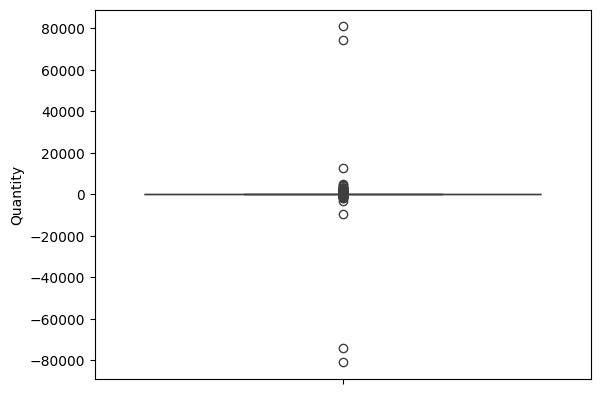

In [1262]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.boxplot(retail_df['Quantity'])
plt.show()

Hay algo muy interesante, y es que hay casos en donde contamos con valores de cantidad negativos!

In [1263]:
devoluciones_df = retail_df[retail_df['Quantity'] < 0]
print("Registros con devolución: ", devoluciones_df.shape[0], "/", retail_df.shape[0])
devoluciones_df.head()

Registros con devolución:  8905 / 406829


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom


Como vemos estas instancias corresponden a devoluciones o cancelaciones. Sabemos esto porque el InvoiceNo comienza con la letra C. Vamos a eliminar del dataset todas estas instancias de devolucion que no nos sirven para el analisis de RFM.

In [1264]:
retail_df = retail_df[retail_df['Quantity'] > 0]

Y el boxplot ahora se ve asi:

<Axes: ylabel='Quantity'>

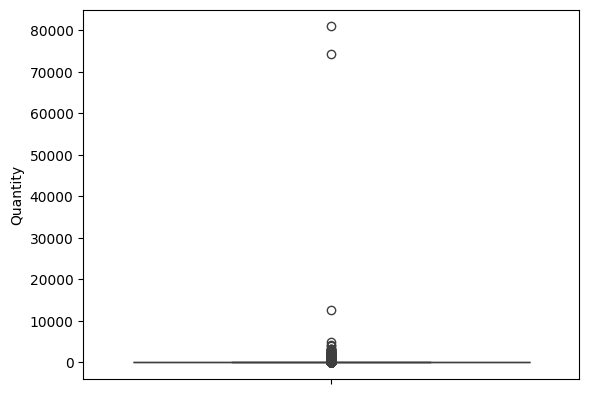

In [1265]:
sns.boxplot(retail_df['Quantity'])

Siguen llamando la atencion tres ventas muy por encima del resto. Estamos hablando de los outliers que se ven por arriba de 10000 unidades.

In [1266]:
retail_df[retail_df['Quantity'] > 10000].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,2011-11-25 15:57:00,0.00,13256.0,United Kingdom
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom


No vamos a mentir que el numero de unidades compradas parece extraño. Vamos a ver en total cuantas unidades de estos productos se vendieron.

In [1267]:
print(f'Cantidad total de unidades vendidas de cualquier producto: {retail_df["Quantity"].sum()}')
print(f'Cantidad total de unidades vendidas de MEDIUM CERAMIC TOP STORAGE JAR: {retail_df[retail_df["StockCode"] == 23166].Quantity.sum()}')
print(f'Cantidad total de unidades vendidas de ASSTD DESIGN 3D PAPER STICKERS: {retail_df[retail_df["StockCode"] == 84826].Quantity.sum()}')
print(f'Cantidad total de unidades vendidas de PAPER CRAFT , LITTLE BIRDIE: {retail_df[retail_df["StockCode"] == 23843].Quantity.sum()}')

Cantidad total de unidades vendidas de cualquier producto: 5181696
Cantidad total de unidades vendidas de MEDIUM CERAMIC TOP STORAGE JAR: 77916
Cantidad total de unidades vendidas de ASSTD DESIGN 3D PAPER STICKERS: 13702
Cantidad total de unidades vendidas de PAPER CRAFT , LITTLE BIRDIE: 80995


Analizando los datos vimos algo interesante. Las ventas y devoluciones pueden corresponderse. Es el caso de PAPER CRAFT, que como podemos ver solo tiene una venta de 80995 unidades. Cuando vemos las devoluciones podemos notar que, en realidad, la venta fue cancelada inmediatamente.

In [1268]:
retail_df[retail_df['StockCode'] == 23843]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom


In [1269]:
devoluciones_df[devoluciones_df['StockCode'] == 23843]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2011-12-09 09:27:00,2.08,16446.0,United Kingdom


Esto es claramente un problema. Estamos hablando de compras que nunca se quisieron realizar, por lo que no deberian contar en nuestro RFM. Estas ventas alteran nuestro analisis con errores y ventas "fantasma".

Queremos analizar cuales son las compras que tienen una devolucion asociada y en cuanto tiempo se hizo esa devolucion.

In [1270]:
# Aseguramos que las fechas estén en formato datetime
retail_df['InvoiceDate'] = pd.to_datetime(retail_df['InvoiceDate'])
devoluciones_df['InvoiceDate'] = pd.to_datetime(devoluciones_df['InvoiceDate'])
devoluciones_df['Quantity'] = -devoluciones_df['Quantity']

merged = pd.merge(
    devoluciones_df,
    retail_df,
    on=['CustomerID', 'StockCode', 'Quantity'],
    suffixes=('_dev', '_comp')
)

# Filtramos solo donde la compra fue antes que la devolución
merged = merged[merged['InvoiceDate_comp'] < merged['InvoiceDate_dev']]

# Calculamos diferencia de tiempo en horas
merged['Diferencia_Horas'] = (merged['InvoiceDate_dev'] - merged['InvoiceDate_comp']).dt.total_seconds() / 3600

# Ordenamos para tomar la compra más reciente antes de la devolución
merged = merged.sort_values(by=['InvoiceNo_dev', 'Diferencia_Horas'])

# Para cada devolución, nos quedamos con la compra más cercana
matched = merged.groupby('InvoiceNo_dev').first().reset_index()

result_df = matched[[
    'CustomerID',
    'StockCode',
    'Description_dev',
    'InvoiceNo_comp', 'InvoiceDate_comp',
    'InvoiceNo_dev', 'InvoiceDate_dev',
    'Quantity',
    'Diferencia_Horas'
]]

# Renombramos para mayor claridad
result_df.columns = [
    'CustomerID',
    'StockCode',
    'Description_dev',
    'InvoiceNo_Compra', 'Fecha_Compra',
    'InvoiceNo_Devolucion', 'Fecha_Devolucion',
    'Cantidad_Devuelta',
    'Diferencia_Horas'
]

result_df.sort_values(by='Diferencia_Horas').head()

,CustomerID,StockCode,Description_dev,InvoiceNo_Compra,Fecha_Compra,InvoiceNo_Devolucion,Fecha_Devolucion,Cantidad_Devuelta,Diferencia_Horas
84,14606.0,20772,GARDEN PATH JOURNAL,540526,2011-01-09 13:41:00,C540527,2011-01-09 13:42:00,1,0.016667
312,12669.0,M,Manual,548913,2011-04-05 09:45:00,C548914,2011-04-05 09:46:00,1,0.016667
569,17865.0,21621,VINTAGE UNION JACK BUNTING,557110,2011-06-16 16:26:00,C557111,2011-06-16 16:27:00,12,0.016667
354,13811.0,M,Manual,550354,2011-04-18 10:28:00,C550355,2011-04-18 10:29:00,1,0.016667
247,16029.0,22933,BAKING MOULD EASTER EGG MILK CHOC,546734,2011-03-16 11:49:00,C546735,2011-03-16 11:50:00,144,0.016667


Vamos a ver un histograma de la cantidad de horas que se tardo en cancelar o devolver.

<Axes: xlabel='Diferencia_Horas', ylabel='Count'>

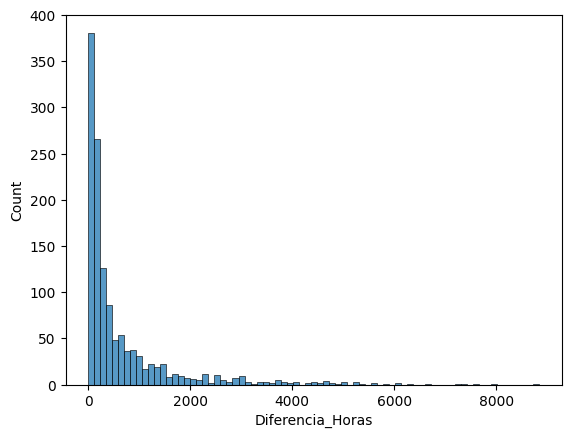

In [1271]:
sns.histplot(result_df['Diferencia_Horas'])

La diferencia de tiempo es muy variada. Esto claramente corresponde a devoluciones y cancelaciones. En este caso queremos contar las devoluciones porque las consideramos compras deseadas que por algun motivo fueron devueltas, quizas porque el producto estaba roto. Por otro lado, las cancelaciones rapidas deberian ser eliminadas ya que las consideramos compras realizadas por error y que no sirven para el analisis real de los clientes.

Al no poder diferenciar realmente entre cancelaciones y devoluciones vamos a eliminar todas aquellas compras en donde haya una Invoice "C" que le corresponda en las siguientes 72 horas, un tiempo razonable para esperar una cancelación.

In [1272]:
delete_devolutions_df = result_df[result_df['Diferencia_Horas'] < 72]
delete_devolutions_df


,CustomerID,StockCode,Description_dev,InvoiceNo_Compra,Fecha_Compra,InvoiceNo_Devolucion,Fecha_Devolucion,Cantidad_Devuelta,Diferencia_Horas
0,17841.0,84685,BEACH HUT KEY CABINET,536557,2010-12-01 14:41:00,C536979,2010-12-03 14:23:00,1,47.700000
1,12748.0,20685,DOORMAT RED RETROSPOT,537140,2010-12-05 12:53:00,C537143,2010-12-05 12:58:00,1,0.083333
2,15880.0,35953,FOLKART STAR CHRISTMAS DECORATIONS,537144,2010-12-05 13:00:00,C537157,2010-12-05 13:09:00,24,0.150000
4,13497.0,21349,IVY HEART WREATH,537298,2010-12-06 11:37:00,C537314,2010-12-06 11:42:00,4,0.083333
5,15882.0,22865,HAND WARMER OWL DESIGN,537377,2010-12-06 13:01:00,C537379,2010-12-06 13:12:00,10,0.183333
...,...,...,...,...,...,...,...,...,...
1259,14126.0,20961,STRAWBERRY BATH SPONGE,579404,2011-11-29 12:21:00,C580174,2011-12-02 11:45:00,50,71.400000
1261,13969.0,23544,WALL ART MID CENTURY MODERN,580092,2011-12-01 14:38:00,C580312,2011-12-02 15:09:00,1,24.516667
1286,15525.0,23079,TOADSTOOL BEDSIDE LIGHT,581166,2011-12-07 14:43:00,C581178,2011-12-07 15:39:00,1,0.933333
1291,15877.0,22959,WRAP CHRISTMAS VILLAGE,581325,2011-12-08 11:53:00,C581330,2011-12-08 11:57:00,25,0.066667


Se eliminaran 281 ventas de esta forma.

In [1273]:
print(f'Cantidad de ventas antes de eliminar devoluciones: {retail_df.shape[0]}')

# Creamos un set de tuplas con las combinaciones exactas a eliminar
productos_devueltos = set(zip(delete_devolutions_df['InvoiceNo_Compra'], delete_devolutions_df['StockCode']))

# Filtramos las filas en retail_df que no están en productos_devueltos
retail_df = retail_df[~retail_df.apply(lambda row: (row['InvoiceNo'], row['StockCode']) in productos_devueltos, axis=1)]

# Verificamos que se hayan eliminado las filas correctamente
print(f'Cantidad de ventas despues de eliminar devoluciones: {retail_df.shape[0]}')
retail_df


Cantidad de ventas antes de eliminar devoluciones: 397924
Cantidad de ventas despues de eliminar devoluciones: 397622


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


Ahora los outliers por arriba de 60000 unidades no aparecen. Claramente habian sido una compra realizada por error que fueron canceladas de inmediato.

<Axes: ylabel='Quantity'>

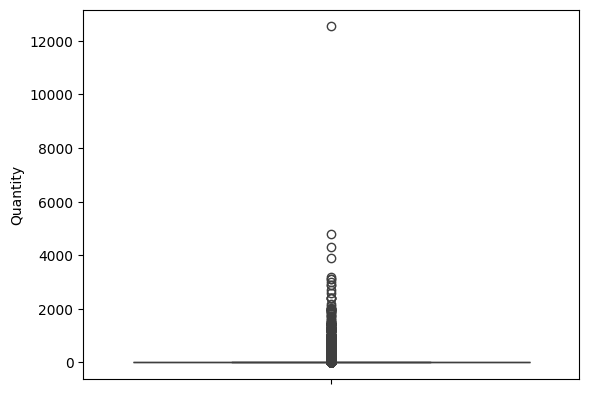

In [1274]:
sns.boxplot(retail_df['Quantity'])

La compra de 12540 ASSTD DESIGN 3D PAPER STICKERS parece ser genuina. No existe una devolucion con esa cantidad y ese CustomerID.

In [1275]:
retail_df[retail_df['Quantity'] > 10000]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,2011-11-25 15:57:00,0.0,13256.0,United Kingdom


In [1276]:
devoluciones_df[devoluciones_df['StockCode'] == 84826]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
29066,C538702,84826,ASSTD DESIGN 3D PAPER STICKERS,60,2010-12-14 10:28:00,0.85,13008.0,United Kingdom


Vamos a revisar el precio por unidad de los articulos vendidos. Estos deberian ser mayores que cero y en ningun caso negativos.

In [1277]:
retail_df['UnitPrice'].describe()

count    397622.000000
mean          3.085393
std          21.533161
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max        8142.750000
Name: UnitPrice, dtype: float64

No hay valores negativos, pero si que valen cero. Esto es interesante porque no sabemos exacatamente que significa, es un error? tal vez una oferta de 2x1 o donde cierto producto no se cobra al llevar otro? compensacion por algun motivo?

In [1278]:
retail_df[retail_df['UnitPrice'] <= 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,2010-12-05 14:02:00,0.0,12647.0,Germany
33576,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,2010-12-16 14:36:00,0.0,16560.0,United Kingdom
40089,539722,22423,REGENCY CAKESTAND 3 TIER,10,2010-12-21 13:45:00,0.0,14911.0,EIRE
47068,540372,22090,PAPER BUNTING RETROSPOT,24,2011-01-06 16:41:00,0.0,13081.0,United Kingdom
47070,540372,22553,PLASTERS IN TIN SKULLS,24,2011-01-06 16:41:00,0.0,13081.0,United Kingdom
56674,541109,22168,ORGANISER WOOD ANTIQUE WHITE,1,2011-01-13 15:10:00,0.0,15107.0,United Kingdom
86789,543599,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,16,2011-02-10 13:08:00,0.0,17560.0,United Kingdom
130188,547417,22062,CERAMIC BOWL WITH LOVE HEART DESIGN,36,2011-03-23 10:25:00,0.0,13239.0,United Kingdom
139453,548318,22055,MINI CAKE STAND HANGING STRAWBERY,5,2011-03-30 12:45:00,0.0,13113.0,United Kingdom
145208,548871,22162,HEART GARLAND RUSTIC PADDED,2,2011-04-04 14:42:00,0.0,14410.0,United Kingdom


Queremos ver si las facturas de estas ventas tienen asociado algun otro producto.

In [1279]:
#Lets see if there are any other products associated with these invoices
with_zero_unit_df = retail_df[retail_df['InvoiceNo'].isin(retail_df[retail_df['UnitPrice'] <= 0]['InvoiceNo'])].groupby('InvoiceNo').size()
with_zero_unit_df.sort_values(ascending=False)

InvoiceNo
540372    171
577696     63
571035     58
577314     35
539722     29
568158     25
550188     23
547417     22
574920     22
539263     21
537197     17
569716     14
574252     11
562973     10
561669      8
572893      8
548871      7
548318      7
561284      6
574138      5
554037      4
553000      4
564651      4
577168      3
574175      3
575579      3
574879      3
577129      2
541109      2
561916      2
574469      2
543599      1
568384      1
578841      1
dtype: int64

La gran mayoria cuentan con mas de un producto en la factura, vamos a considerar que se tratan de productos entregados gratuitamente como promocion o para prueba. Veamos que pasa con las facturas que tienen precio cero.

In [1280]:
zero_price_df = retail_df.copy()[retail_df['InvoiceNo'].isin(with_zero_unit_df.index)]
zero_price_df['TotalPrice'] = zero_price_df['Quantity'] * zero_price_df['UnitPrice']
zero_price_df = zero_price_df.groupby('InvoiceNo')["TotalPrice"].sum()
zero_price_df = zero_price_df[zero_price_df == 0]
zero_price_df


InvoiceNo
543599    0.0
564651    0.0
568384    0.0
578841    0.0
Name: TotalPrice, dtype: float64

In [1281]:
retail_df[retail_df['InvoiceNo'].isin(zero_price_df.index)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
86789,543599,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,16,2011-02-10 13:08:00,0.0,17560.0,United Kingdom
314745,564651,23270,SET OF 2 CERAMIC PAINTED HEARTS,96,2011-08-26 14:19:00,0.0,14646.0,Netherlands
314746,564651,23268,SET OF 2 CERAMIC CHRISTMAS REINDEER,192,2011-08-26 14:19:00,0.0,14646.0,Netherlands
314747,564651,22955,36 FOIL STAR CAKE CASES,144,2011-08-26 14:19:00,0.0,14646.0,Netherlands
314748,564651,21786,POLKADOT RAIN HAT,144,2011-08-26 14:19:00,0.0,14646.0,Netherlands
361825,568384,M,Manual,1,2011-09-27 09:46:00,0.0,12748.0,United Kingdom
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,2011-11-25 15:57:00,0.0,13256.0,United Kingdom


A estas facturas de valor cero vamos a eliminarlas. No deben corresponder a compras por parte de los clientes o son ajustes de cuentas. Esto puede afectar a los valores de Frecuency o Recency de los clientes que tienen estas facturas, indicando que compraron mas o mas recientemente de lo que verdaderamente hicieron.

Decidimos eliminarlo debido a que son muy pocas instancias. Podriamos haber reemplazado el precio con el precio de la unidad de otra venta, sin embargo la aparicion de la venta de 12540 ASSTD DESIGN 3D PAPER STICKERS nos da a entender que hay algo extranio con estas ventas. Por esa razon decidimos eliminarlas.

In [1282]:
retail_df = retail_df[~retail_df['InvoiceNo'].isin(zero_price_df.index)]

Vamos a eliminar repetidos tambien.

In [1283]:
print('Instancias duplicadas: {}'.format(retail_df.duplicated().sum()))
retail_df = retail_df.drop_duplicates()
print('Instancias duplicadas: {}'.format(retail_df.duplicated().sum()))


Instancias duplicadas: 5179
Instancias duplicadas: 0


La ultima cosa que consideramos extrania es que, a lo largo del analisis, en los stock code hemos visto algunos extranios. Estos tienen solo letras y menos de cinco digitos, que no corresponden a la descripcion.

In [1284]:
retail_df['StockCode'] = retail_df['StockCode'].astype(str)
anomaly_stock_codes = retail_df[(retail_df['StockCode']).str.contains('^[a-zA-Z]',regex=True)]['StockCode']
print(f"Cantidad de StockCode que no cumplen con el formato: {anomaly_stock_codes.nunique()} \n")
for stock_code in anomaly_stock_codes.unique():
    desc = retail_df[retail_df['StockCode'] == stock_code]
    print(f"{stock_code} ---> {desc['Description'].iloc[0]}")
print(f"\nInstancias de StockCode que no cumplen con el formato: {anomaly_stock_codes.shape[0]}")

Cantidad de StockCode que no cumplen con el formato: 6 

POST ---> POSTAGE
C2 ---> CARRIAGE
M ---> Manual
BANK CHARGES ---> Bank Charges
PADS ---> PADS TO MATCH ALL CUSHIONS
DOT ---> DOTCOM POSTAGE

Instancias de StockCode que no cumplen con el formato: 1516


Estas corresponden a servicio como envios, bank charges, pads para el envio, etc. No estamos seguros de considerar estas instancias. En el caso del envio por ejemplo puede variar demasiado segun el pais desde donde compra el cliente. Esto puede ser bueno o malo, es cierto que cosas como el envio pueden ser ruido en el valor monetario, pero tambien hay una cuestion de que esos clientes lejanos tienen otro ritmo de compra.

Por ahora decidimos eliminar estas instancias ya que no representan exacatamente una compra de un producto y pueden alterar algunos valores.

In [1285]:
print(f"Shape antes de eliminar: {retail_df.shape}")
retail_df = retail_df[~retail_df['StockCode'].str.contains('^[a-zA-Z]',regex=True)]
print(f"Shape despues de eliminar: {retail_df.shape}")

Shape antes de eliminar: (392436, 8)
Shape despues de eliminar: (390920, 8)


# Analisis RFM

Luego de realizar la primera limpieza del dataset vamos a proceder a crear las variables para el RFM analysis y visualizar sus distribuciones.

El análisis RFM es una técnica de segmentación de clientes basada en su comportamiento de compra. Se utiliza para identificar grupos de clientes más valiosos y dirigir mejor las estrategias de marketing, fidelización y retención.

RFM es un acrónimo de:

- R de Recency: Cuánto tiempo ha pasado desde la última compra del cliente.
- F	de Frequency: Cuántas veces ha comprado el cliente en un período determinado.
- M de Monetary: Cuánto dinero ha gastado el cliente en total.

### Recency

Para el calculo del recency tomamos como fecha de referencia el ultimo dia del dataset mas uno.

In [1286]:
fecha_referencia = retail_df['InvoiceDate'].max() + pd.Timedelta(days=1)
fecha_referencia

Timestamp('2011-12-10 12:50:00')

Y usamos la fecha de invoice mas alta de cada cliente para restarle a esa fecha de referencia. Convertimos ese valor a dias.

In [1287]:
recency_df = retail_df.groupby('CustomerID')['InvoiceDate'].max().reset_index()
recency_df['Recency'] = (fecha_referencia - recency_df['InvoiceDate']).dt.days
recency_df.head()

,CustomerID,InvoiceDate,Recency
0,12347.0,2011-12-07 15:52:00,2
1,12348.0,2011-09-25 13:13:00,75
2,12349.0,2011-11-21 09:51:00,19
3,12350.0,2011-02-02 16:01:00,310
4,12352.0,2011-11-03 14:37:00,36


### Frequency

Para el frequency lo unico que vamos a hacer es contar la cantidad de facturas unicas que hay para cada cliente.

In [1288]:
frequency_df = retail_df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
frequency_df.rename(columns={'InvoiceNo': 'Frequency'}, inplace=True)
frequency_df.head()

,CustomerID,Frequency
0,12347.0,7
1,12348.0,4
2,12349.0,1
3,12350.0,1
4,12352.0,7


### Monetary

Por ultimo, para monetary vamos a sumar crear una nueva columna en el dataframe original que contenga el valor de cada item. Luego vamos a realizar la suma de todos estos valores para cada cliente. Esto nos da el valor total de compra para cada cliente dentro del periodo del dataset.

In [1289]:
retail_df['TotalPrice'] = retail_df['Quantity'] * retail_df['UnitPrice']

monetary_df = retail_df.groupby('CustomerID')['TotalPrice'].sum().reset_index()
monetary_df.rename(columns={'TotalPrice': 'Monetary'}, inplace=True)
monetary_df.head()

,CustomerID,Monetary
0,12347.0,4310.00
1,12348.0,1437.24
2,12349.0,1457.55
3,12350.0,294.40
4,12352.0,1385.74


### Crear dataset final

Finalmente debemos unir todos los dataset creados segun el customerID.

In [1290]:
rfm_df = recency_df.merge(frequency_df, on='CustomerID')
rfm_df = rfm_df.merge(monetary_df, on='CustomerID')
rfm_df.head()

,CustomerID,InvoiceDate,Recency,Frequency,Monetary
0,12347.0,2011-12-07 15:52:00,2,7,4310.00
1,12348.0,2011-09-25 13:13:00,75,4,1437.24
2,12349.0,2011-11-21 09:51:00,19,1,1457.55
3,12350.0,2011-02-02 16:01:00,310,1,294.40
4,12352.0,2011-11-03 14:37:00,36,7,1385.74


In [1291]:
print("Total de clientes: ", rfm_df.shape[0])

Total de clientes:  4333


### Analisis Bivariado inicial

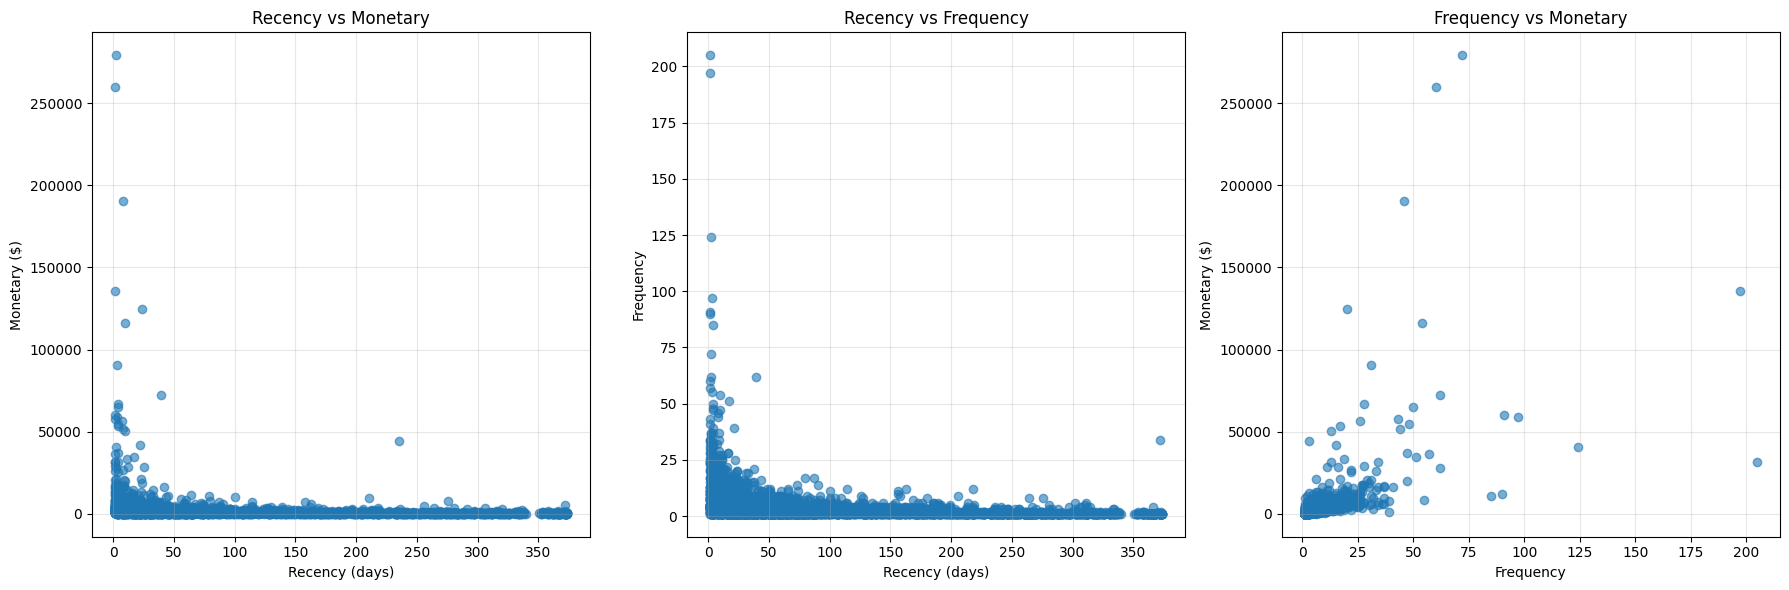

In [1292]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Recency vs Monetary
axes[0].scatter(rfm_df['Recency'], rfm_df['Monetary'], alpha=0.6)
axes[0].set_xlabel('Recency (days)')
axes[0].set_ylabel('Monetary ($)')
axes[0].set_title('Recency vs Monetary')
axes[0].grid(True, alpha=0.3)

# Plot 2: Recency vs Frequency
axes[1].scatter(rfm_df['Recency'], rfm_df['Frequency'], alpha=0.6)
axes[1].set_xlabel('Recency (days)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Recency vs Frequency')
axes[1].grid(True, alpha=0.3)

# Plot 3: Frequency vs Monetary
axes[2].scatter(rfm_df['Frequency'], rfm_df['Monetary'], alpha=0.6)
axes[2].set_xlabel('Frequency')
axes[2].set_ylabel('Monetary ($)')
axes[2].set_title('Frequency vs Monetary')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Distribuciones

A continuacion observaremos la distribucion que tienen las variables RFM obtenidas.

In [1293]:
def plot_rfm_distributions(df, title_suffix="", figsize=(18, 6), bins=50, describe=False):
    """
    Función para visualizar las distribuciones de Recency, Frequency y Monetary.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame con columnas 'Recency', 'Frequency', 'Monetary'
    title_suffix : str, optional
        Sufijo para agregar a los títulos de los gráficos
    figsize : tuple, optional
        Tamaño de la figura (width, height)
    bins : int, optional
        Número de bins para los histogramas
    """
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    # Configuración de colores y datos
    plot_config = [
        {'column': 'Recency', 'color': 'skyblue', 'xlabel': 'Recency (days)', 'title': 'Distribution of Recency'},
        {'column': 'Frequency', 'color': 'lightgreen', 'xlabel': 'Frequency', 'title': 'Distribution of Frequency'},
        {'column': 'Monetary', 'color': 'salmon', 'xlabel': 'Monetary ($)', 'title': 'Distribution of Monetary'}
    ]
    
    # Crear los histogramas
    for i, config in enumerate(plot_config):
        axes[i].hist(df[config['column']], bins=bins, alpha=0.7, 
                    color=config['color'], edgecolor='black')
        axes[i].set_xlabel(config['xlabel'])
        axes[i].set_ylabel('Frequency')
        axes[i].set_title(f"{config['title']}{title_suffix}")
        axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


    if describe:
        # Print summary statistics
        print("Summary Statistics for RFM Variables:")
        print("\nRecency:")
        print(df['Recency'].describe())
        print("\nFrequency:")
        print(df['Frequency'].describe())
        print("\nMonetary:")
        print(df['Monetary'].describe())

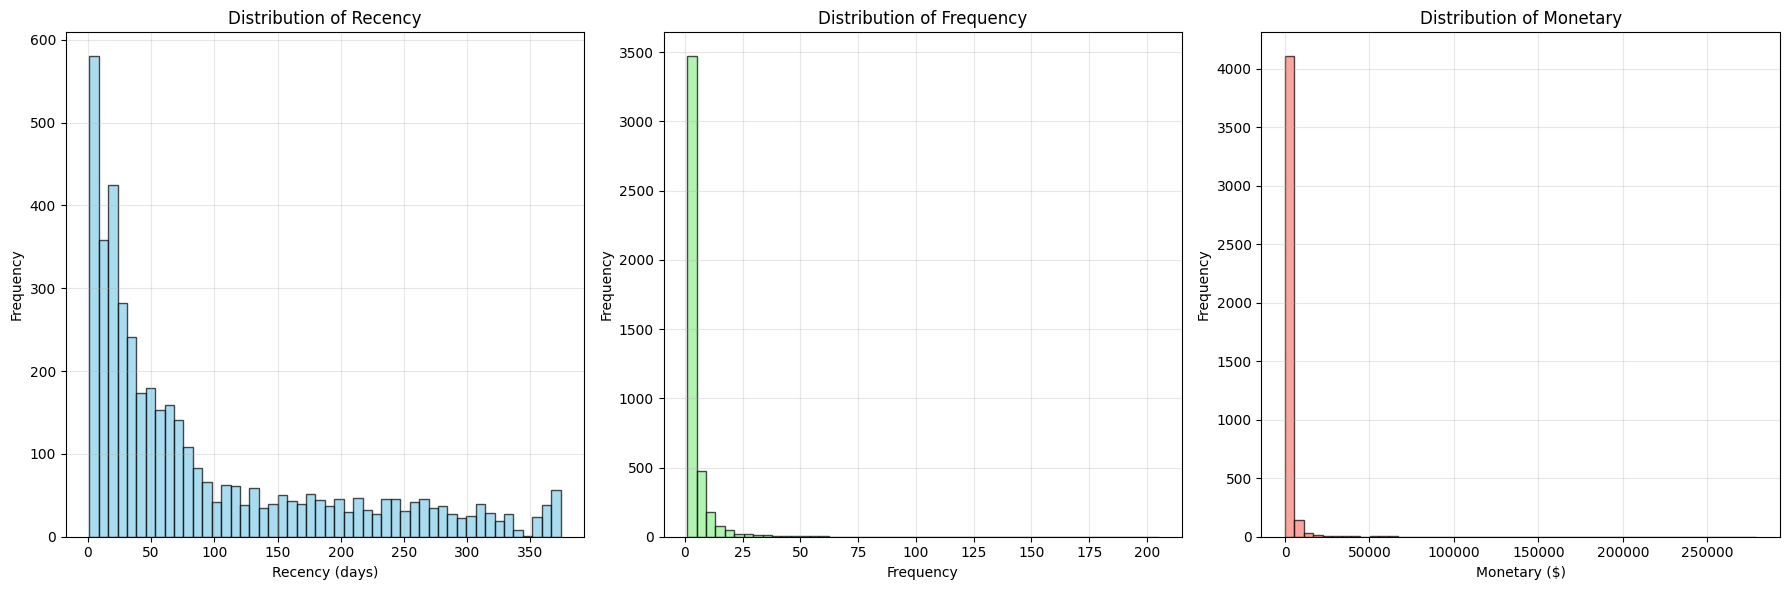

Summary Statistics for RFM Variables:

Recency:
count    4333.000000
mean       92.704131
std       100.127823
min         1.000000
25%        18.000000
50%        51.000000
75%       143.000000
max       374.000000
Name: Recency, dtype: float64

Frequency:
count    4333.000000
mean        4.241634
std         7.617743
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max       205.000000
Name: Frequency, dtype: float64

Monetary:
count      4333.000000
mean       1946.481934
std        8415.221990
min           2.900000
25%         302.700000
50%         659.460000
75%        1624.110000
max      279138.020000
Name: Monetary, dtype: float64


In [1294]:
plot_rfm_distributions(rfm_df, describe=True)

Observamos que en nuestra empresa la mayoria de los clientes tienen pocos pedidos y bajo gasto.

A simple vista observamos que las 3 variables tienen una distribución exponencial, siendo la de Recency la mas apreciable. Para el caso de Frequency y Monetary no resulta sencillo ver a simple vista la distribucion por completo debido a que existen pocas ocurrencias para los valores mayores. Por lo tanto, podríamos identificar aquellos registros que causan esto y analizarlos.

Analizamos registros con Frequency mayor a 40 y con Monetary mayor a 25000

In [1295]:
# Analizar registros con Frequency > 40
high_frequency = rfm_df[rfm_df['Frequency'] > 40]
print(f"Registros con Frequency > 40: {len(high_frequency)}")
if len(high_frequency) > 0:
    print("\nRegistros con Frequency > 40:")
    print(high_frequency.head())

# Analizar registros con Monetary > 25000
high_monetary = rfm_df[rfm_df['Monetary'] > 25000]
print(f"\nRegistros con Monetary > 25000: {len(high_monetary)}")
if len(high_monetary) > 0:
    print("\nRegistros con Monetary > 25000:")
    print(high_monetary.head())

# Verificar si hay registros que cumplan ambas condiciones
both_conditions = rfm_df[(rfm_df['Frequency'] > 40) & (rfm_df['Monetary'] > 25000)]
print(f"\nRegistros que cumplen ambas condiciones (Frequency > 40 Y Monetary > 25000): {len(both_conditions)}")
if len(both_conditions) > 0:
    print("\nRegistros que cumplen ambas condiciones:")
    print(both_conditions.head())


Registros con Frequency > 40: 23

Registros con Frequency > 40:
     CustomerID         InvoiceDate  Recency  Frequency  Monetary
325     12748.0 2011-12-09 12:20:00        1        205  31464.09
480     12971.0 2011-12-06 12:20:00        4         85  10969.76
561     13089.0 2011-12-07 09:02:00        3         97  58762.08
794     13408.0 2011-12-08 09:05:00        2         62  28102.04
995     13694.0 2011-12-06 09:32:00        4         50  65039.62

Registros con Monetary > 25000: 35

Registros con Monetary > 25000:
     CustomerID         InvoiceDate  Recency  Frequency   Monetary
54      12415.0 2011-11-15 14:22:00       24         20  124562.45
325     12748.0 2011-12-09 12:20:00        1        205   31464.09
452     12931.0 2011-11-18 12:39:00       22         15   42055.96
557     13081.0 2011-11-28 10:54:00       12         11   28337.38
561     13089.0 2011-12-07 09:02:00        3         97   58762.08

Registros que cumplen ambas condiciones (Frequency > 40 Y Monetary >

Como se aprecia, son pocos clientes para cada caso. Ademas se trata de clientes que muestran un comportamiento de compras altamente recurrente, con compras hechas recientemente y por consiguiente un buen flujo de dinero. Dicho esto, probablemente pertenezcan a un grupo selecto de clientes (Clientes VIP) que podrían ser analizados por aparte y dejar en manos de la clusterización al resto de clientes. Por lo tanto tenemos dos alternativas: 1) No considerar a los clientes VIP y que la clusterizacion sea para segmentar un "cliente promedio" en la empresa o 2) Trabajar con el total de los datos. De momento tomamos la segunda alternativa.

Identificamos los vips para no perderlos

In [1296]:
clients_df = rfm_df.copy()
clients_df['Is_VIP'] = (clients_df['Frequency'] >= 40) | (clients_df['Monetary'] >= 25000) # Notese el OR

Preparamos las funciones para las transformaciones y la muestra de distribuciones para que sea mas facil modificar en caso de seguir explorando

A continuacion se muestran todas las transformaciones probadas para evaluar y ver cuales convienen para cada caso y en caso de cambiar de algoritmos volver a estas graficas para probar/escoger las mejores para cada algoritmo. Como primer abordaje intentaremos alcanzar la mejor combinacion de Transformador-Escalador para algoritmos de distancia euclideana como KMeans y Agglomerative probando distintas combinaciones.

In [ ]:
import numpy as np
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, StandardScaler, RobustScaler

def apply_transformations(df, only_scaled=False):
    std_scaler = StandardScaler()
    rob_scaled = RobustScaler()
    
    if only_scaled:
        return {
            'Standard': std_scaler.fit_transform(df),
            'Robust': rob_scaled.fit_transform(df),
        }
    # --------------- Log ---------------
    X_log = np.log1p(df)

    X_log_std_scaled = std_scaler.fit_transform(X_log)
    X_log_rob_scaled = rob_scaled.fit_transform(X_log)


    # --------- Yeo-Johnson transform ---------
    pt = PowerTransformer(method='yeo-johnson')
    X_pt = pt.fit_transform(df)

    X_pt_std_scaled = std_scaler.fit_transform(X_pt)
    X_pt_rob_scaled = rob_scaled.fit_transform(X_pt)


    # --------- Quantile transform ---------
    qt = QuantileTransformer(output_distribution='normal', random_state=42)
    X_qt = qt.fit_transform(df)

    X_qt_std_scaled = std_scaler.fit_transform(X_qt)
    X_qt_rob_scaled = rob_scaled.fit_transform(X_qt)

    return {
        'Log-Standard': X_log_std_scaled,
        'Log-Robust': X_log_rob_scaled,

        'Power-Standard': X_pt_std_scaled,
        'Power-Robust': X_pt_rob_scaled,

        'Quantile-Standard': X_qt_std_scaled,
        'Quantile-Robust': X_qt_rob_scaled,
    }


def plot_distributions(dataframes_dict, figsize=(15, 10)):
    """
    Plot distributions for multiple dataframes with different transformations.
    
    Parameters:
    -----------
    dataframes_dict : dict
        Dictionary with keys as transformation names and values as numpy arrays
    figsize : tuple
        Figure size (width, height)
    """
    n_transformations = len(dataframes_dict)
    n_features = dataframes_dict[list(dataframes_dict.keys())[0]].shape[1]
    
    fig, axes = plt.subplots(n_features, n_transformations, figsize=figsize)
    
    # If only one transformation, make axes 2D
    if n_transformations == 1:
        axes = axes.reshape(-1, 1)
    
    feature_names = ['Recency', 'Frequency', 'Monetary']
    
    for col_idx, (transformation_name, data) in enumerate(dataframes_dict.items()):
        for row_idx in range(n_features):
            ax = axes[row_idx, col_idx] if n_transformations > 1 else axes[row_idx]
            
            # Plot histogram
            ax.hist(data[:, row_idx], bins=30, alpha=0.7, edgecolor='black')
            ax.set_title(f'{transformation_name}\n{feature_names[row_idx]}')
            ax.set_xlabel('Value')
            ax.set_ylabel('Frequency')
            ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

##### Con todos los clientes

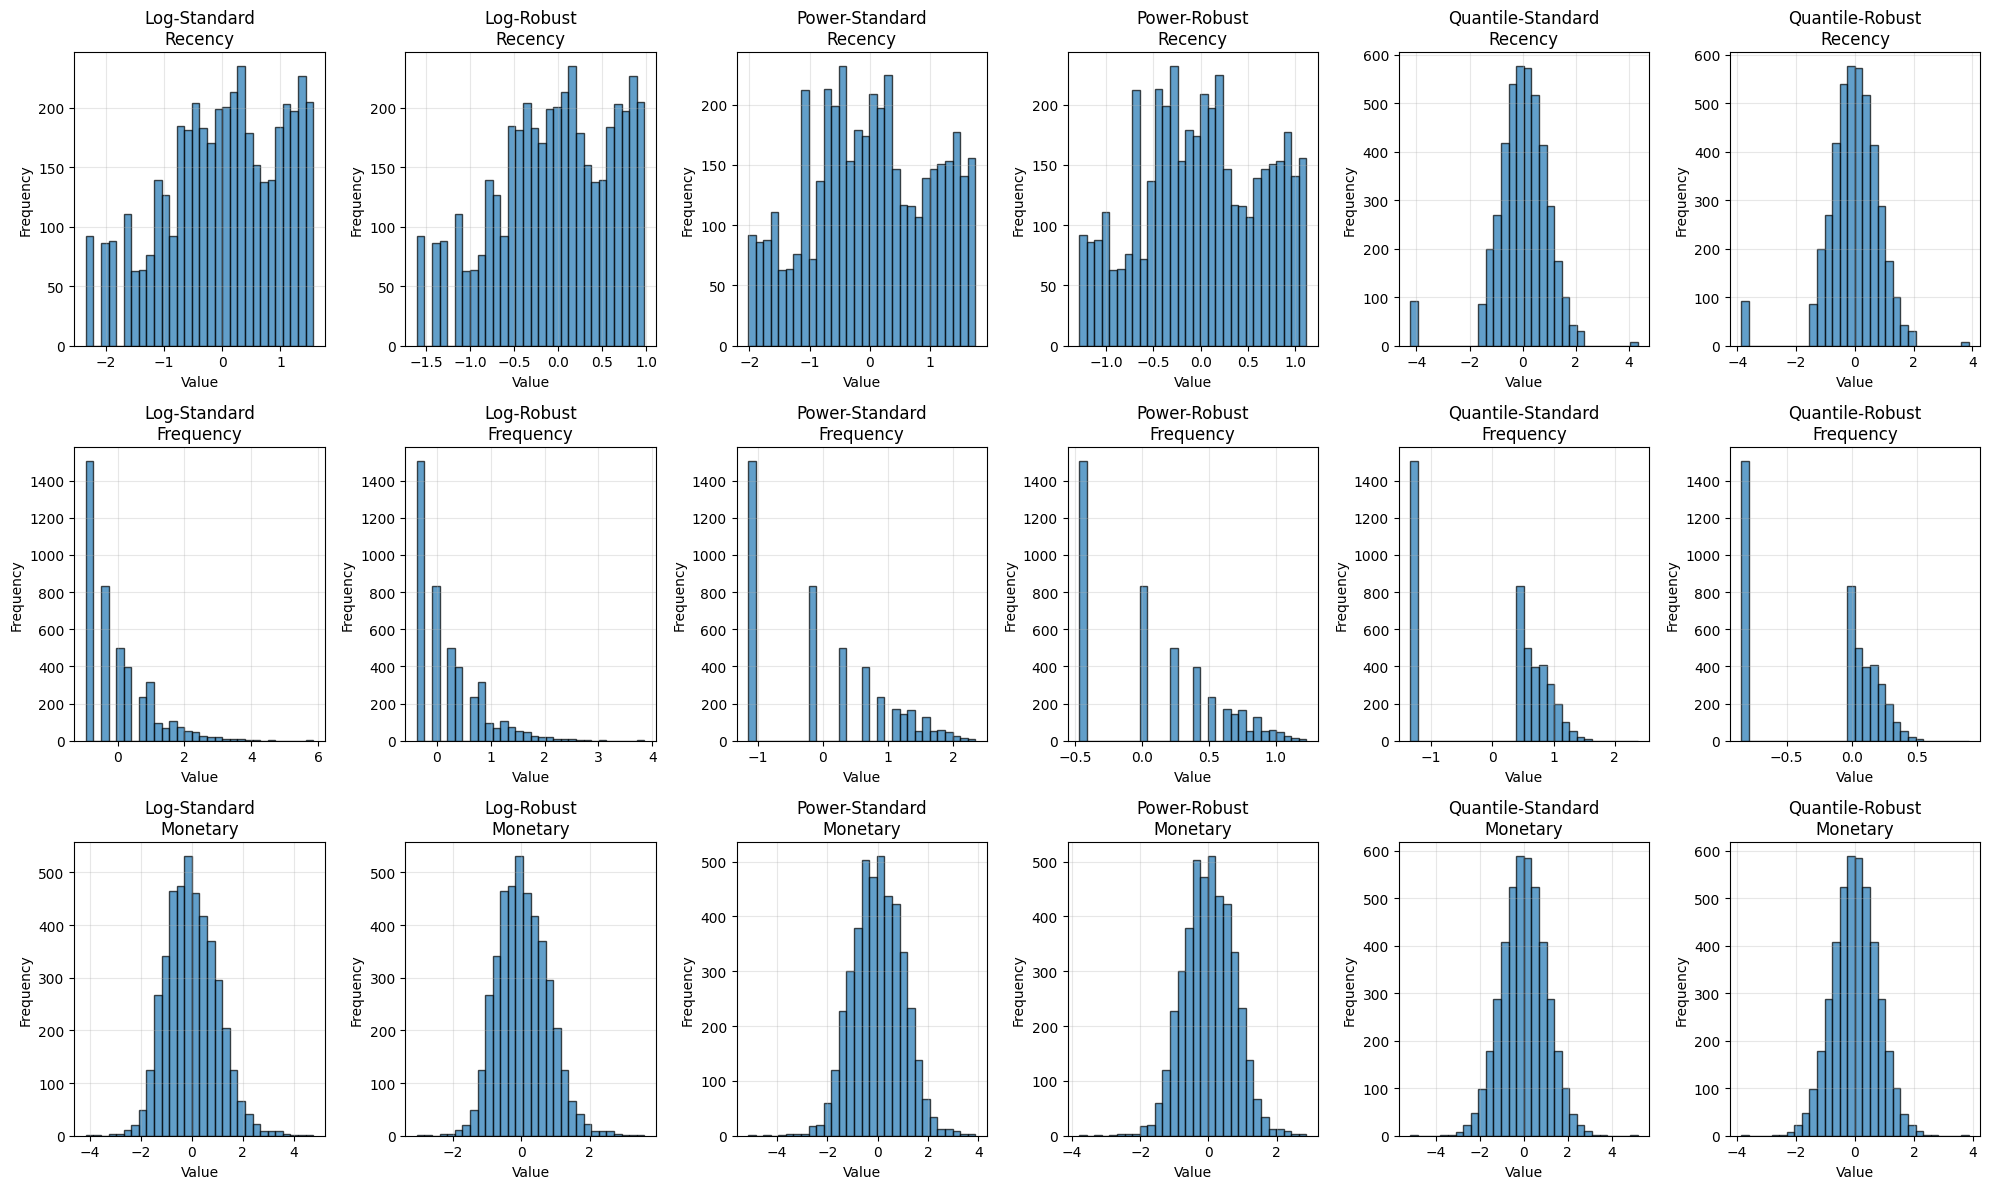

In [1337]:
transformations_dict = apply_transformations(clients_df[['Recency', 'Frequency', 'Monetary']])

plot_distributions(transformations_dict, figsize=(20, 12))


##### Todos menos los VIP

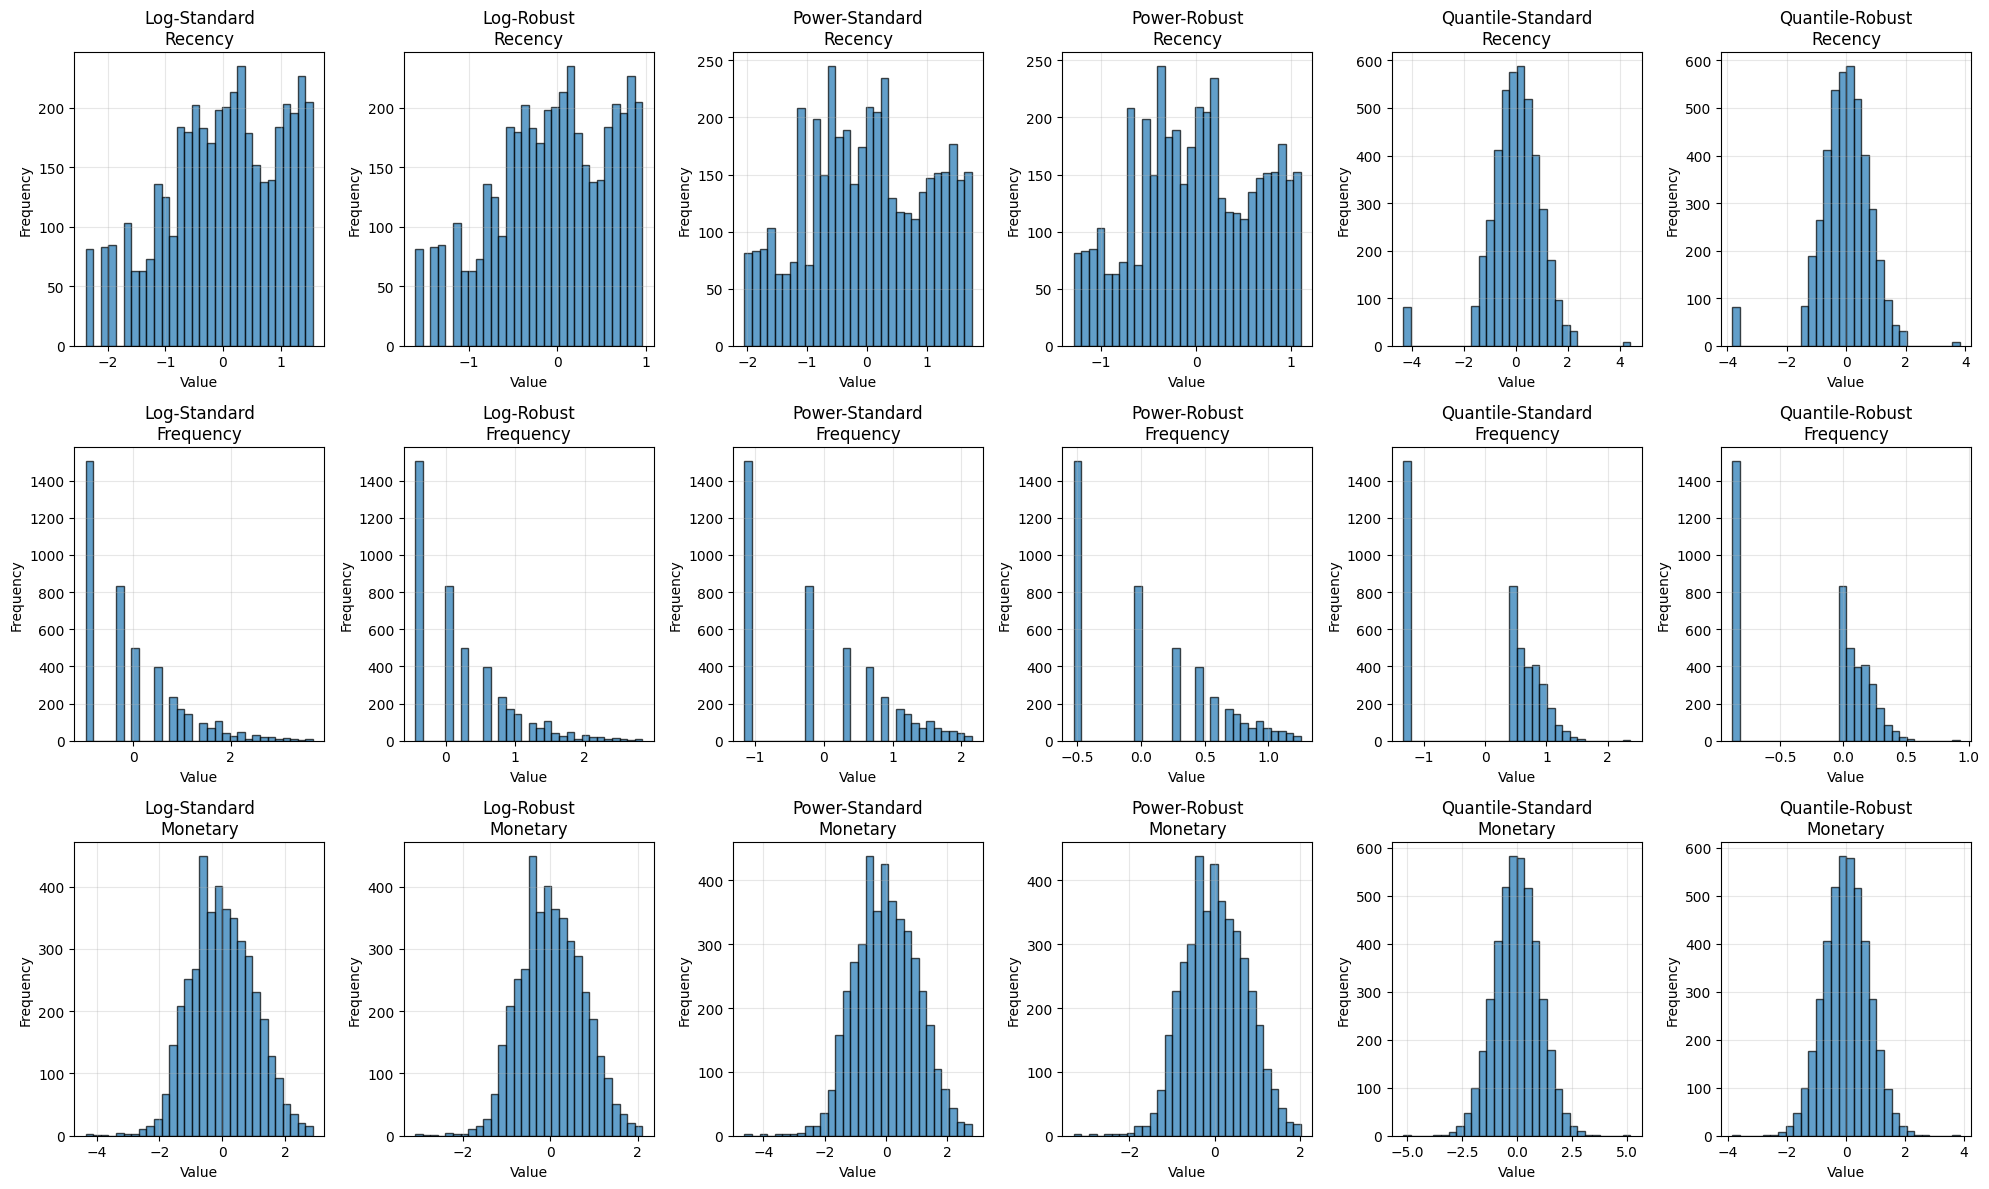

In [1338]:
transformations_dict = apply_transformations(clients_df[~clients_df['Is_VIP']][['Recency', 'Frequency', 'Monetary']])

plot_distributions(transformations_dict, figsize=(20, 12))

Vemos que el incluir o no los clientes VIP no afecta significativamente al momento de hacer las transformaciones. Aun asi, nos mantenemos sin tomar una decision definitiva. Sigamos analizando

En base a los experimentos anteriores se enuncian las alternativas para transformar los datos:

CON CLIENTES VIP:


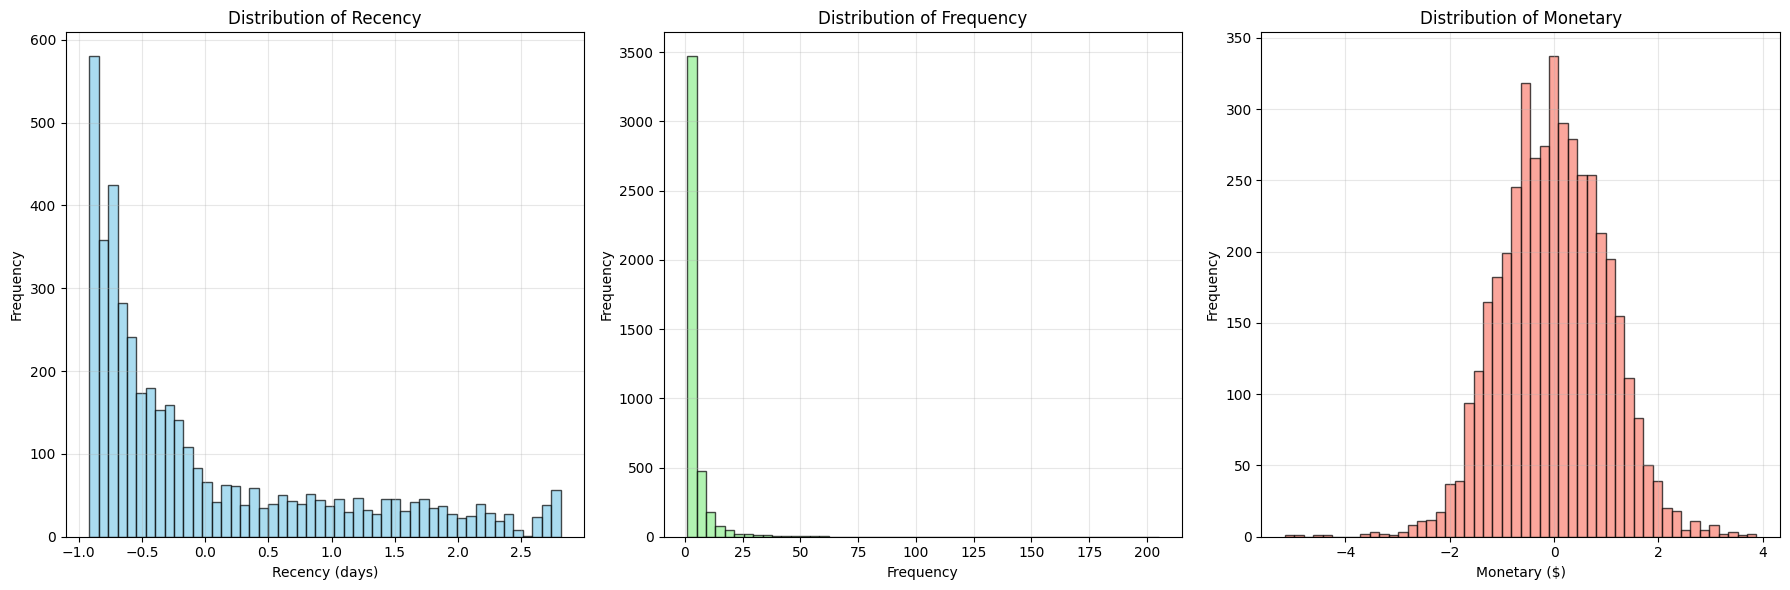

SIN CLIENTES VIP:


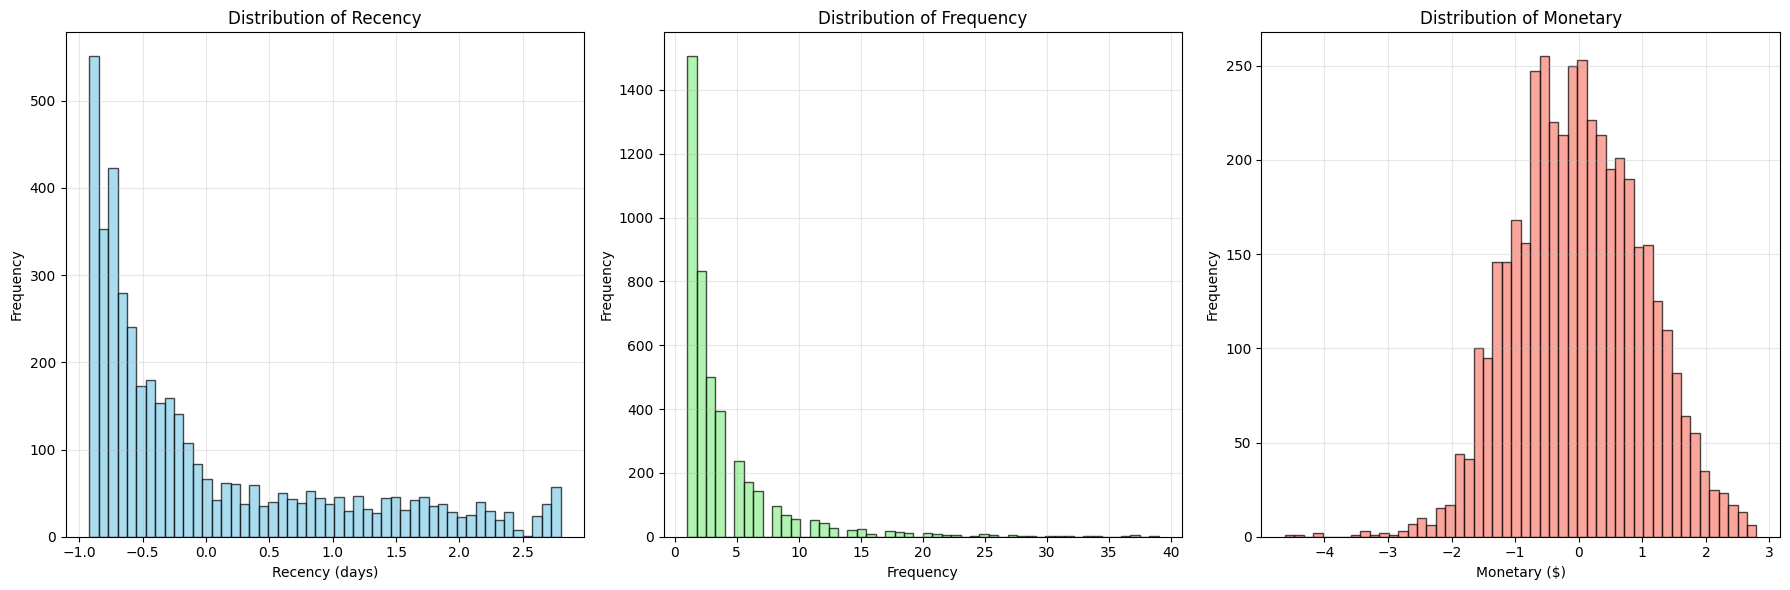

In [ ]:
transformed_df = clients_df.copy()

transformations_dict = apply_transformations(transformed_df[['Recency']], only_scaled=True)
transformed_df['Recency'] = transformations_dict['Standard']

# No tocamos Frequency
# transformations_dict = apply_transformations(transformed_df[['Frequency']], only_scaled=True)
# transformed_df['Frequency'] = transformations_dict['Standard']

transformations_dict = apply_transformations(transformed_df[['Monetary']])
transformed_df['Monetary'] = transformations_dict['Power-Standard'] # la quantile es muy perfecta, esta mantiene un poco mas de la varianza


print("CON CLIENTES VIP:")
plot_rfm_distributions(transformed_df)

transformed_df_no_vip = clients_df[~clients_df['Is_VIP']].copy()

transformations_dict = apply_transformations(transformed_df_no_vip[['Recency']], only_scaled=True)
transformed_df_no_vip['Recency'] = transformations_dict['Standard']

# No tocamos Frequency
# transformations_dict = apply_transformations(transformed_df_no_vip[['Frequency']], only_scaled=True)
# transformed_df_no_vip['Frequency'] = transformations_dict['Standard']

transformations_dict = apply_transformations(transformed_df_no_vip[['Monetary']])
transformed_df_no_vip['Monetary'] = transformations_dict['Power-Standard'] # la quantile es muy perfecta, esta mantiene un poco mas de la varianza

print("SIN CLIENTES VIP:")
plot_rfm_distributions(transformed_df_no_vip)

### Analisis Bivariado Posterior

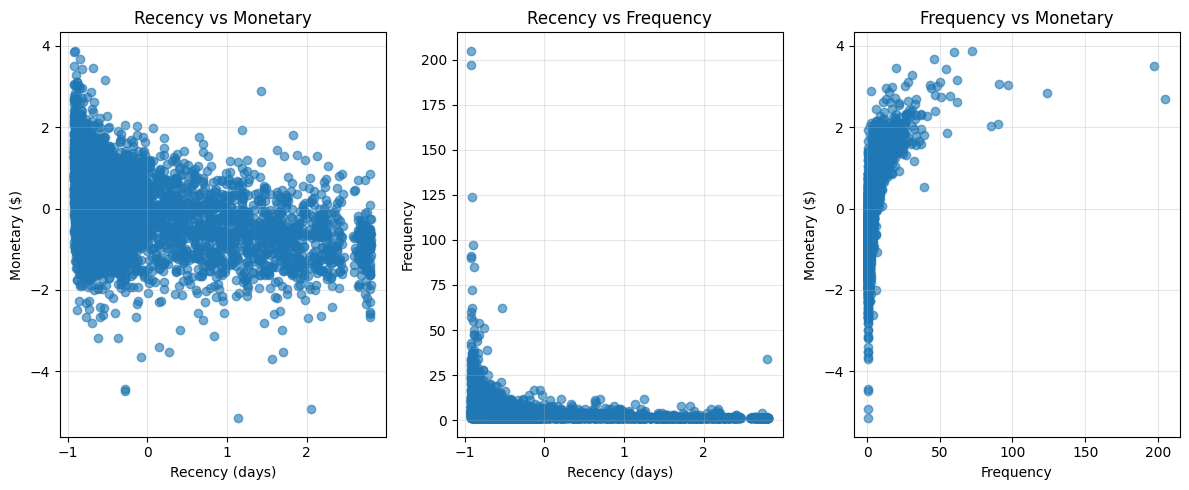

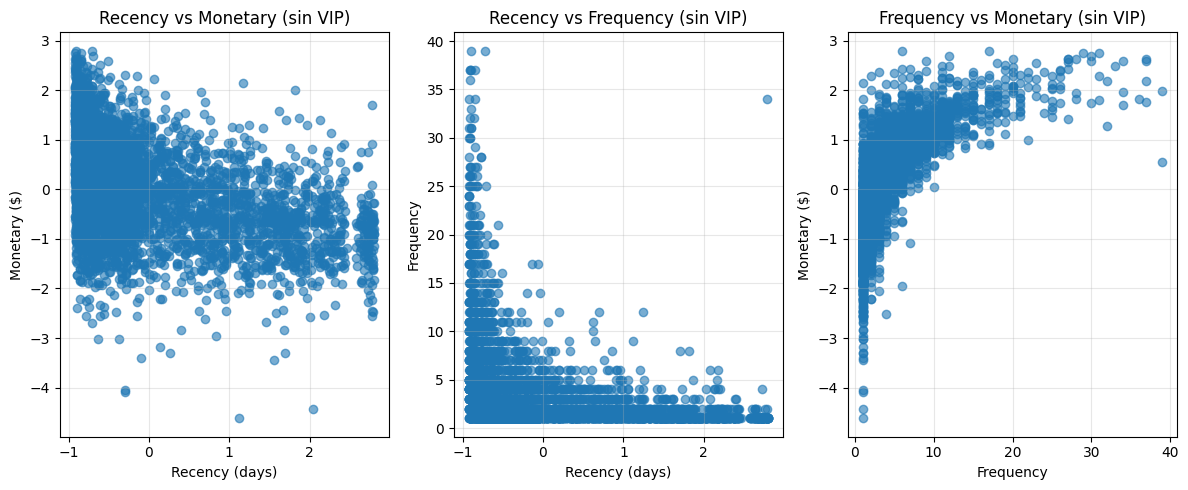

In [1360]:
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

# Plot 1: Recency vs Monetary
axes[0].scatter(transformed_df['Recency'], transformed_df['Monetary'], alpha=0.6)
axes[0].set_xlabel('Recency (days)')
axes[0].set_ylabel('Monetary ($)')
axes[0].set_title('Recency vs Monetary')
axes[0].grid(True, alpha=0.3)

# Plot 2: Recency vs Frequency
axes[1].scatter(transformed_df['Recency'], transformed_df['Frequency'], alpha=0.6)
axes[1].set_xlabel('Recency (days)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Recency vs Frequency')
axes[1].grid(True, alpha=0.3)

# Plot 3: Frequency vs Monetary
axes[2].scatter(transformed_df['Frequency'], transformed_df['Monetary'], alpha=0.6)
axes[2].set_xlabel('Frequency')
axes[2].set_ylabel('Monetary ($)')
axes[2].set_title('Frequency vs Monetary')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Análisis bivariado para transformed_df_no_vip
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

# Plot 1: Recency vs Monetary (sin VIP)
axes[0].scatter(transformed_df_no_vip['Recency'], transformed_df_no_vip['Monetary'], alpha=0.6)
axes[0].set_xlabel('Recency (days)')
axes[0].set_ylabel('Monetary ($)')
axes[0].set_title('Recency vs Monetary (sin VIP)')
axes[0].grid(True, alpha=0.3)

# Plot 2: Recency vs Frequency (sin VIP)
axes[1].scatter(transformed_df_no_vip['Recency'], transformed_df_no_vip['Frequency'], alpha=0.6)
axes[1].set_xlabel('Recency (days)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Recency vs Frequency (sin VIP)')
axes[1].grid(True, alpha=0.3)

# Plot 3: Frequency vs Monetary (sin VIP)
axes[2].scatter(transformed_df_no_vip['Frequency'], transformed_df_no_vip['Monetary'], alpha=0.6)
axes[2].set_xlabel('Frequency')
axes[2].set_ylabel('Monetary ($)')
axes[2].set_title('Frequency vs Monetary (sin VIP)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Vemos como los clientes VIP podrian considerarse outliers tranquilamente ya que lo unico que agregan hasta el momento es mayor varianza en los datos.

Algo notable es que se observa un efecto de "rayas" en el grafico de dispersion debido a que la frecuencia es un valor discreto. Esto no vale la pena cambiar.